In [1]:
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from codvidutils.Autoencoder_Uncertainty_Transformation_main import Transformation_main
from codvidutils.Transformation_class import Transformation
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import normalize
from scipy.stats import norm
from codvidutils.imageproc import map_categorical
from PIL import Image
from keras.models import load_model
import pickle

Using TensorFlow backend.


In [2]:
Y_test = []
preds = []
for it in range(10):
    preds += [np.loadtxt('log/preds_XGBr_Uncertainty_{}.txt'.format(it+1), delimiter=',')]

trns = Transformation('data/train_split_v4.csv', 'data/test_split_v5.csv')
#------------Read images and prepare dataset------------#
train_class, test_class = trns.read_imgs_paths()
X_train, X_test, diseaseID_train, diseaseID_test = trns.read_imgs(train_class, test_class)
del train_class, test_class
#------------Imbalanced methods------------#
X_train, X_test, diseaseID_train = trns.underbalance(X_train, X_test, diseaseID_train)
print('X_train.shape: {}\nX_test.shape: {}'.format(X_train.shape, X_test.shape))
print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)
_, X_test, _, diseaseID_test = trns.new_imgs(X_train, X_test, diseaseID_train, diseaseID_test)
del diseaseID_train
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0
X_test = X_test/255

You are going to read from: data/train_split_v4.csv and data/test_split_v5.csv
Total number of images: 1524
shape X: 13600 1524,  disease_ID (Y): 13600 1524
Count of classes:  Counter({0: 7966, 2: 5447, 1: 187})
New diseaseID shape:  (9187,)
New X shape:  (9187, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 187})
Undersample shapes:
diseaseID_train.shape: (9187,)
X_train.shape: (9187, 120000)
X_train.shape: (9187, 200, 200, 3)
X_test.shape: (1524, 200, 200, 3)
Normal train:  (4500,)
Pneumonia train:  (4500,)
COVID train:  (187,)
*******************************************************
Normal test:  (880,)
Pneumonia test:  (586,)
COVID test:  (58,)
(4675, 180, 180, 3)
(4675,)
X_train.shape:  (13862, 180, 180, 3)
diseaseID_train.shape:  (13862,)
X_test_news.shape:  (1450, 180, 180, 3)
diseaseID_test_news.shape:  (1450,)
X_test.shape:  (2974, 180, 180, 3)
diseaseID_test.shape:  (2974,)


In [3]:
predictive_mean = np.mean(preds, axis=0)
predictive_variance = np.var(preds, axis=0)
nocovid = predictive_mean[np.where(Y_test == 0)]
nocovid_variance = predictive_variance[np.where(Y_test == 0)]
covid = predictive_mean[np.where(Y_test == 1)]
covid_variance = predictive_variance[np.where(Y_test == 1)]
print("Mean: {}\nStd: {}".format(predictive_mean, predictive_variance))

Mean: [0.31004757 0.66796421 0.59996191 ... 0.65907161 0.6299399  0.36241553]
Std: [0.00089636 0.00088725 0.00073477 ... 0.00063517 0.00068005 0.00066005]


In [4]:
# Total Error = E_random + E_systematic
#E_t = np.sqrt(predictive_variance + 0.225**2)
E_t = np.sqrt(predictive_variance)
nocovid_variance = E_t[np.where(Y_test == 0)]
covid_variance = E_t[np.where(Y_test == 1)]
print("Total error: {}".format(E_t))

Total error: [0.02993935 0.02978681 0.02710668 ... 0.02520263 0.02607778 0.02569134]


In [5]:
predictive_mean_up = predictive_mean + E_t
predictive_mean_down = predictive_mean - E_t

# Confusion matrices

In [6]:
def ConfMatrix(Y_test, preds, cut=0.50):
    TP = np.count_nonzero(np.where((Y_test==0) & (preds<cut)))
    FN = np.count_nonzero(np.where((Y_test==1) & (preds>cut)))
    FP = np.count_nonzero(np.where((Y_test==1) & (preds<cut)))
    TN = np.count_nonzero(np.where((Y_test==0) & (preds>cut)))
    out = np.array([[TP, TN],[FP, FN]])
    return out

In [7]:
cm_up = ConfMatrix(Y_test, predictive_mean_up, cut=0.5)
cm = ConfMatrix(Y_test, predictive_mean, cut=0.5)
print('{} of {} no COVID-19 ({:2.4}%)'.format(cm[0,0], cm[0,0] + cm[0,1], 100*cm[0,0]/(cm[0,0]+cm[0,1])))
print('{} of {} COVID-19 ({:2.3}%)'.format(cm[1,1], cm[1,1] + cm[1,0], 100*cm[1,1]/(cm[1,1]+cm[1,0])))
print("Means + E_t:\n{}".format(cm))
cm_down = ConfMatrix(Y_test, predictive_mean_down, cut=0.5)
# Distance taking into account the error interval
dist_up = np.absolute(cm_up - cm)
dist_down = np.absolute(cm - cm_down)
print("Upper distance:\n{}".format(dist_up))
print("Lower distance:\n{}".format(dist_down))

1327 of 1466 no COVID-19 (90.52%)
779 of 1507 COVID-19 (51.7%)
Means + E_t:
[[1327  139]
 [ 728  779]]
Upper distance:
[[54 54]
 [90 90]]
Lower distance:
[[ 51  51]
 [134 134]]


# Histograms

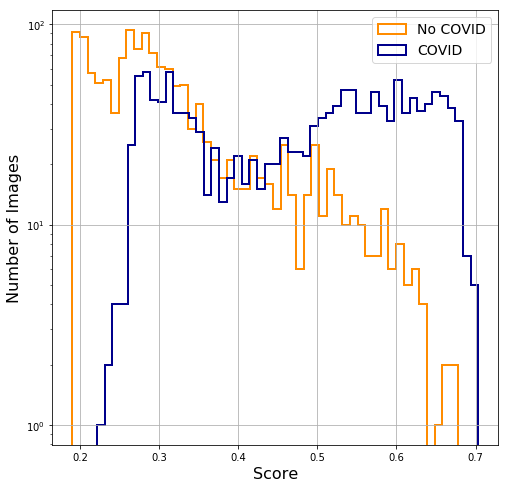

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(nocovid, 50, histtype='step', lw=2, color='darkorange', label='No COVID')
ax.hist(covid, 50, histtype='step', lw=2, color='darkblue', label='COVID')
plt.grid()
ax.set_ylabel('Number of Images', fontsize=16)
ax.set_xlabel('Score', fontsize=16)
plt.legend( loc='upper right', fontsize=14)
plt.yscale("log")
fig.savefig('Figures/histogram_Uncertainty_XGBr.eps', dpi=200)

## Curva ROC

In [24]:
fpr, tpr, thresholds = roc_curve(Y_test, predictive_mean)
fpr_U, tpr_U, thr = roc_curve(Y_test, predictive_mean_up)
fpr_L, tpr_L, thr = roc_curve(Y_test, predictive_mean_down)
roc_auc = auc(fpr, tpr)
roc_auc_U = auc(fpr_U, tpr_U)
roc_auc_L = auc(fpr_L, tpr_L)

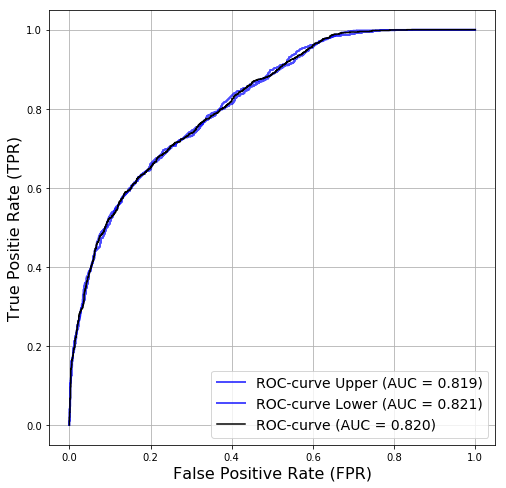

In [25]:
fig3, ax3 =plt.subplots(figsize=(8,8))
ax3.plot(fpr_U, tpr_U, color='blue',lw=2, label='ROC-curve Upper (AUC = %0.3f)' % (roc_auc_U), alpha=0.7)
ax3.plot(fpr_L, tpr_L, color='blue',lw=2, label='ROC-curve Lower (AUC = %0.3f)' % (roc_auc_L), alpha=0.7)
ax3.plot(fpr, tpr, color='k', label='ROC-curve (AUC = %0.3f)' % (roc_auc))
ax3.set_ylabel('True Positie Rate (TPR)', fontsize=16)
ax3.set_xlabel('False Positive Rate (FPR)', fontsize=16)
plt.grid()
plt.legend(loc="lower right", fontsize=14)
fig3.savefig('Figures/ROC')
plt.show()


# Histogram with Bernoulli integration

In [8]:
def integration(data, var, nbins):
    g = np.linspace(0, 1, nbins+1)
    #g[0] = -np.inf
    #g[-1] = np.inf
    sP = (len(data), nbins)
    output = np.zeros(sP)
    for i in range(len(data)):
        for j in range(nbins):
            output[i,j] = (norm.cdf(g[j+1], loc=data[i], scale=var[i]) - norm.cdf(g[j], loc=data[i], scale=var[i]))
    return g, output

In [9]:
g, P_covid = integration(covid, covid_variance, 30)
_, P_nocovid = integration(nocovid, nocovid_variance, 30)

In [10]:
counts_covid= np.sum(P_covid, axis=0)
counts_nocovid= np.sum(P_nocovid, axis=0)
variance_covid = np.sqrt(np.sum(np.multiply(P_covid, (1 - P_covid)), axis=0))
variance_nocovid = np.sqrt(np.sum(np.multiply(P_nocovid, (1 - P_nocovid)), axis=0))

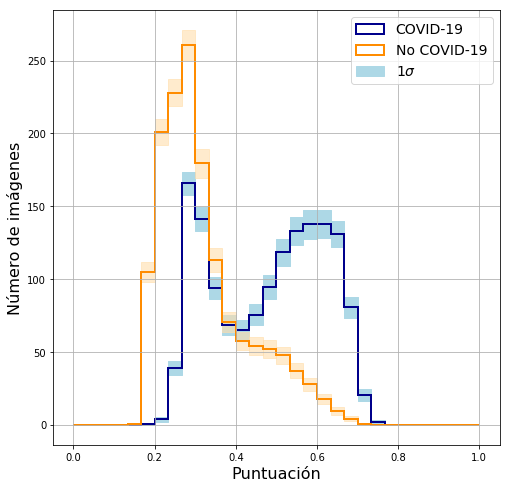

In [12]:
fig4, ax4 = plt.subplots(figsize = (8,8))
for i in range(counts_covid.shape[0]):
    ax4.fill_between(g[i:i+2], counts_covid[i] - variance_covid[i], counts_covid[i] + variance_covid[i], color='lightblue')
    ax4.fill_between(g[i:i+2], counts_nocovid[i] - variance_nocovid[i], counts_nocovid[i] + variance_nocovid[i], 
                     color='navajowhite', alpha=0.6)
ax4.hist(g[:-1], g, weights=counts_covid, histtype='step', color='darkblue', lw=2)
ax4.hist(g[:-1], g, weights=counts_nocovid, histtype='step', color='darkorange', lw=2)
ax4.set_ylabel("Número de imágenes", fontsize=16)
ax4.set_xlabel("Puntuación", fontsize=16)
plt.legend(['COVID-19', 'No COVID-19', '$1\sigma$'], fontsize=14)
plt.grid()
fig4.savefig('Figures/histogram_Uncertainty_Integration_XGBr.png', dpi=200)

# 3 Histograms: covid vs pneumonia vs normal

In [13]:
predictive_mean = np.mean(preds, axis=0)
predictive_variance = np.var(preds, axis=0)
neumonia = predictive_mean[np.where(diseaseID_test == 0)]
neumonia_variance = predictive_variance[np.where(diseaseID_test == 0)]
normal = predictive_mean[np.where(diseaseID_test == 2)]
normal_variance = predictive_variance[np.where(diseaseID_test == 2)]
print("Mean: {}\nStd: {}".format(predictive_mean, predictive_variance))

Mean: [0.31004757 0.66796421 0.59996191 ... 0.65907161 0.6299399  0.36241553]
Std: [0.00089636 0.00088725 0.00073477 ... 0.00063517 0.00068005 0.00066005]


In [14]:
_, P_neumonia = integration(neumonia, neumonia_variance, 30)
_, P_normal = integration(normal, normal_variance, 30)

In [15]:
counts_neumonia= np.sum(P_neumonia, axis=0)
counts_normal = np.sum(P_normal, axis=0)
variance_neumonia = np.sqrt(np.sum(np.multiply(P_neumonia, (1 - P_neumonia)), axis=0))
variance_normal = np.sqrt(np.sum(np.multiply(P_normal, (1 - P_normal)), axis=0))

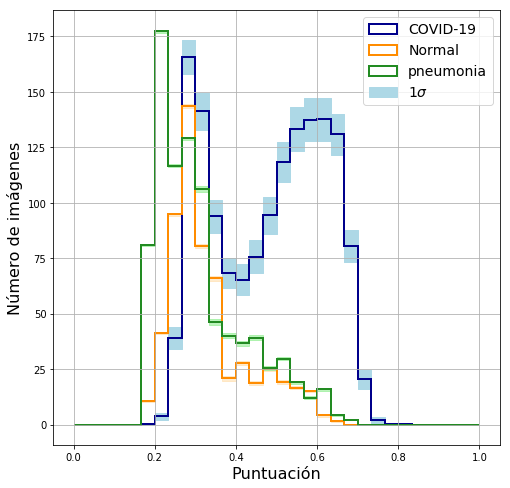

In [16]:
fig4, ax4 = plt.subplots(figsize = (8,8))
for i in range(counts_covid.shape[0]):
    ax4.fill_between(g[i:i+2], counts_covid[i] - variance_covid[i], counts_covid[i] + variance_covid[i], color='lightblue')
    ax4.fill_between(g[i:i+2], counts_normal[i] - variance_normal[i], counts_normal[i] + variance_normal[i], 
                     color='navajowhite', alpha=0.6)
    ax4.fill_between(g[i:i+2], counts_neumonia[i] - variance_neumonia[i], counts_neumonia[i] + variance_neumonia[i], 
                     color='lightgreen', alpha=0.6)
ax4.hist(g[:-1], g, weights=counts_covid, histtype='step', color='darkblue', lw=2)
ax4.hist(g[:-1], g, weights=counts_normal, histtype='step', color='darkorange', lw=2)
ax4.hist(g[:-1], g, weights=counts_neumonia, histtype='step', color='forestgreen', lw=2)
ax4.set_ylabel("Número de imágenes", fontsize=16)
ax4.set_xlabel("Puntuación", fontsize=16)
plt.legend(['COVID-19', 'Normal', 'pneumonia','$1\sigma$'], fontsize=14)
plt.grid()
fig4.savefig('Figures/Three_histograms_Uncertainty_Integration_XGBr.png', dpi=200)

# Final prediction with uncertainties

In [6]:
best_pred_loc = np.where(predictive_mean == np.max(predictive_mean))[0][0]
print(best_pred_loc)

2965


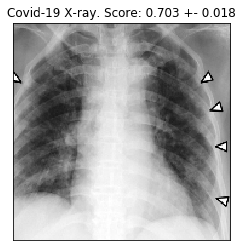

In [7]:
fig, ax = plt.subplots()
ax.imshow(X_test[best_pred_loc])
ax.set_title('Covid-19 X-ray. Score: {:.3} +- {:.2}'.format(predictive_mean[best_pred_loc], 
                                                                  E_t[best_pred_loc]))
ax.set_xticks(())
ax.set_yticks(())
fig.savefig('Figures/Best_prediction_Covid.png', dpi=200)

In [15]:
best_pred_loc = np.where(predictive_mean == np.min(predictive_mean))[0][0]
print(best_pred_loc)

304


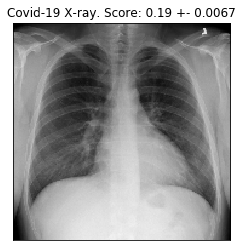

In [16]:
fig, ax = plt.subplots()
ax.imshow(X_test[best_pred_loc])
ax.set_title('Covid-19 X-ray. Score: {:.3} +- {:.2}'.format(predictive_mean[best_pred_loc], 
                                                                  E_t[best_pred_loc]))
ax.set_xticks(())
ax.set_yticks(())
fig.savefig('Figures/Best_prediction_noCovid.png', dpi=200)